In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import scipy.linalg
import scipy.io
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [15]:
#### Import data
data = scipy.io.loadmat('dataSorted.mat')
data = data['out'] 
data = data.round(decimals=4)
print(f'Total of {data.shape}' )

Total of (128, 508, 35, 5)


In [16]:
test_data = data[:,:,0,0]
test_data = np.hstack((test_data,data[:,:,0,1],data[:,:,0,2],data[:,:,0,3],data[:,:,0,4]))
print(test_data.shape)

(128, 2540)


In [17]:
results_test = np.zeros((5,508), dtype=float)
results_test[0,:] = 0.9

results_test2 = np.zeros((5,508), dtype=float)
results_test2[1,:] = 0.9

results_test = np.hstack((results_test,results_test2))

results_test2 = np.zeros((5,508), dtype=float)
results_test2[2,:] = 0.9

results_test = np.hstack((results_test,results_test2))

results_test2 = np.zeros((5,508), dtype=float)
results_test2[3,:] = 0.9

results_test = np.hstack((results_test,results_test2))

results_test2 = np.zeros((5,508), dtype=float)
results_test2[4,:] = 0.9

results_test = np.hstack((results_test,results_test2))

print(results_test.shape)

(5, 2540)


In [18]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None, W_back = None,
                 non_null_matrices = None): 
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        self.W_back = W_back #feedback connections (matrix of size self.N x self.L) (may be None)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
  
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))                
        self.u = None #input (matrix of size self.K x self.T) 
        self.u_test = None #input durint training (matrix of size self.K x t_dismiss+t_autonom) 
      

    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:] 
        
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, boundary_noise=None, t_autonom=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
            -It admits noise, in which case the boundary_noise has to be specified
        
        If test=True
            -Computes the predictions for the desired t_autonom
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            x_prev = self.trajectories[-1,:]
                       
                
        if test == False:             
            if noise == True:
                nu = np.zeros([self.L, self.T])#np.random.uniform(low=-boundary_noise, high=boundary_noise, size=(self.L, self.T))
            elif noise == False:
                nu = np.zeros([self.L, self.T]) 

                
           
        if "W_back" in self.non_null_matrices:
            if test == False:
                aux = np.zeros([self.L,1])
                aux2 = np.copy(self.y_teach)
                y =np.hstack([aux, aux2])
            elif test == True:
                y = self.y_teach[:,-1].reshape(-1,1)                     
   
        
        
        if test == False:
            for n in np.arange(self.T):
                x = np.tanh(np.dot(self.W_in,self.u[:,n])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]+nu[:,n]))
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:            
            for n in np.arange(t_autonom):
                x = np.tanh(np.dot(self.W_in, self.u_test[:,n])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]))
                x_prev = x
                y_next = np.tanh(self.regressor.predict(x.reshape(1,-1)))
                y_next = y_next.reshape(-1,1)
                y = np.hstack([y,y_next])                    
            return y

    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        """
        Args:
            -sel_nodes, list specifying the nodes of the reservoir to be plotted. If sel_nodes=False, it randomly
            selects num_nodes nodes of the reservoir.
        
        Returns:
            -Plots the trajectories of the given nodes.
        """
        
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T+1) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()
            
            
    def train_network(self, plot=False, noise=False, boundary_noise=0.001, ):
        """
        Args:
            -plot, whether we want to plot the trajectories of 10 randomly selected nodes of the reservoir
            -noise, whether we want to add noise when training
            -boundary noise, if noise=True and boundary_noise=a, then the noise is going to be uniformly 
            distributed on the interval [-a,a]
        
        Returns:
            -Performs the training and returns the object self. It computes self.trajectories, self.regressor and
            prints the training MSE component-wise.
        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        #Define the ground truth
        self.initial_state = np.ones(self.N)
        
        #Define y_teach_test                
        """self.y_teach = np.copy(self.u.T)
        for i in np.arange(self.T-1):
            if 0.5 in self.y_teach[i,:]:
                if 0.5 not in self.y_teach[i+1,:]:
                    j = np.argwhere(self.y_teach[i,:]==0.5)[0][0]
                    self.y_teach[i+1,j]=0.5
        self.y_teach[self.y_teach != 0.5] = -0.5
        self.y_teach = self.y_teach.T
        """
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, boundary_noise=boundary_noise)

        #plot some trajectories
        if plot == True:
            self.plot_nodes_trajectories()
            
        regressor = LinearRegression()
        regressor.fit(self.dismiss_transient(self.trajectories[1:,:]), np.arctanh(self.dismiss_transient(self.y_teach.T)))
                
        #Compute MSE
        MSE_vector = 1/(self.T-self.n_min)*sum((np.arctanh(self.dismiss_transient(self.y_teach.T)) - regressor.predict(self.dismiss_transient(self.trajectories[1:,:])))**2)
                         
        if self.L == 1: #in case the output is one dimensional
            print("The training MSE is {}".format(MSE_vector[0])) 
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The training MSE for the {}-th dimension is {}".format(i+1, MSE_vector[i]))        
                                              
        self.regressor = regressor   
        
        return self   
    
    
    
    def test_network(self, t_autonom, outputs=[0,1,2,3,4], plot=False):
        """
        Args:            
            -t_autonom, time we let the network freely run
            -outputs, list giving the channels we want to plot as long as plot=True
            -plot, whether the testing plots are going to be plotted
        
        Returns:
            -The MSE during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """ 
        
        #Define u_test
        self.u_test = self.u        
        
        #Define y_teach_test
        self.y_teach_test = self.y_teach
                  
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_autonom=t_autonom)
        y = y[:,1:]        
        
        
        ##############
        #plot outputs
        ##############
        MSE = 1/t_autonom*sum((self.y_teach_test-y)**2) #compute MSE
        
        if plot == True:
            for dim in outputs:            
                MSE_text = "The MSE of the {}-th channel is {}".format(dim+1, round(MSE[dim],10))
                plt.plot(self.y_teach_test[dim,:], label="Desired output (y_teach)")
                plt.plot(y[dim,:], '--',linewidth=1.0, label="Output of the network during the autonomous time steps")
                plt.title("Channel (component) {}".format(dim+1))
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.gcf().text(0.95, 0.6, MSE_text, fontsize=12)
                plt.show()
                
        for i in np.arange(self.L):
            print("The test MSE for the {}-th dimension is {}".format(i+1, MSE[i]))
            
        
    def final_test_network(self, t_autonom, outputs=[0,1,2,3,4], plot=False):
        """
        Args:            
            -t_autonom, time we let the network freely run
            -outputs, list giving the channels we want to plot as long as plot=True
            -plot, whether the testing plots are going to be plotted
        
        Returns:
            -The MSE during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """ 
        
        #Define u_test
        test_data = data[:,:,1,0]
        test_data = np.hstack((test_data,data[:,:,1,1],data[:,:,1,2],data[:,:,1,3],data[:,:,1,4]))
        self.u_test = test_data        
        
        #Define y_teach_test
        self.y_teach_test = self.y_teach
                  
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_autonom=t_autonom)
        y = y[:,1:]        
        
        
        ##############
        #plot outputs
        ##############
        MSE = 1/t_autonom*sum((self.y_teach_test-y)**2) #compute MSE
        
        if plot == True:
            for dim in outputs:            
                MSE_text = "The MSE of the {}-th channel is {}".format(dim+1, round(MSE[dim],10))
                plt.plot(self.y_teach_test[dim,:], label="Desired output (y_teach)")
                plt.plot(y[dim,:], '--',linewidth=1.0, label="Output of the network during the autonomous time steps")
                plt.title("Channel (component) {}".format(dim+1))
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.gcf().text(0.95, 0.6, MSE_text, fontsize=12)
                plt.show()
                
        for i in np.arange(self.L):
            print("The test MSE for the {}-th dimension is {}".format(i+1, MSE[i]))
            

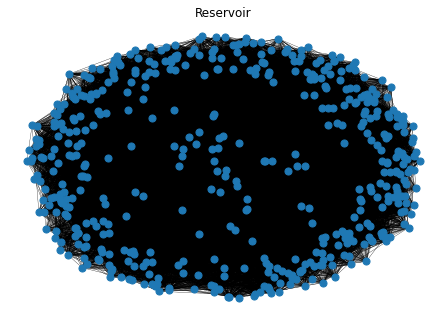

The reservoir has 500 nodes and 12225 edges


In [19]:
########################
# Initialize instance
########################
Network = Network()

########################
# Define the parameters
########################

Network.T = 2540
Network.n_min = 40
Network.K = 128
Network.N = 500
Network.L = 5

Network.u = test_data
Network.y_teach = results_test

Network.initial_state = np.ones(Network.N)


Network.W_in = np.random.choice(np.array([-5,5]), size=(Network.N, Network.K))
Network.W_back = np.random.choice([0,0.1,-0.1], size=(Network.N, Network.L), p=[0.8, 0.1, 0.1])

Network.non_null_matrices = ["W_in","W_back"]



########################
# Reservoir
########################

Network.W = np.zeros([Network.N,Network.N]) #adjacency matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p <0.025:
            Network.W[i,j] = 0.4            
            
        elif 0.025 <= p <0.05:
            Network.W[i,j] = -0.4
            

G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))            


In [20]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 2.0729176962273446
The maximum singular value (in module) is 4.002199421831483


In [21]:
alpha = 0.22/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [22]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 0.22000000000000033
The maximum singular value (in module) is 0.42475582817657614


Since $\sigma_{max}<1$, the existence of echo states is guaranteed.

In [23]:
Network.train_network(plot=False, noise=False, boundary_noise=0.001) 
print(Network.trajectories.shape)#columns -> nodes; rows -> time steps

The training MSE for the 1-th dimension is 0.16807940733657065
The training MSE for the 2-th dimension is 0.17721067690740896
The training MSE for the 3-th dimension is 0.18108431464859018
The training MSE for the 4-th dimension is 0.16267494977596897
The training MSE for the 5-th dimension is 0.17187015124985675
(2541, 500)


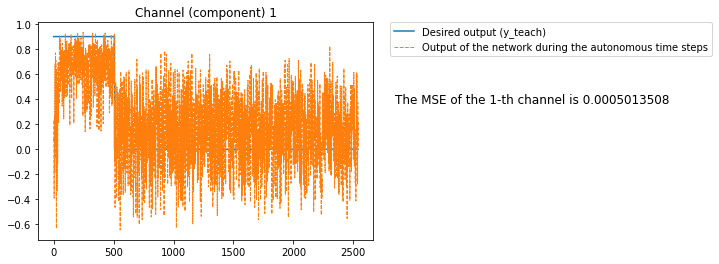

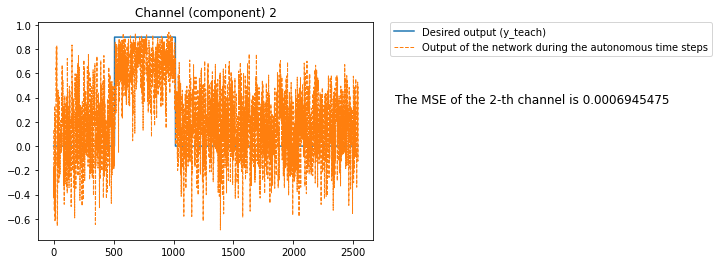

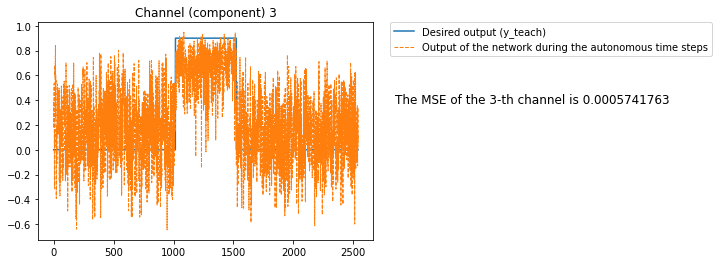

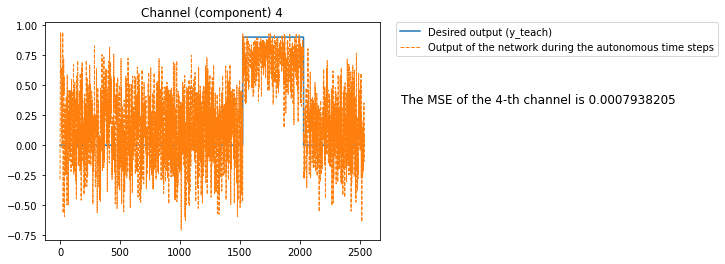

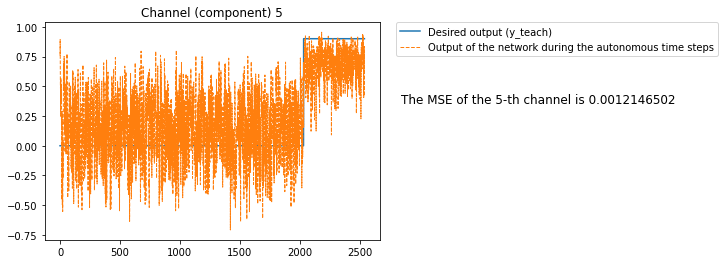

The test MSE for the 1-th dimension is 0.0005013507537331087
The test MSE for the 2-th dimension is 0.0006945475407953031
The test MSE for the 3-th dimension is 0.0005741763281469334
The test MSE for the 4-th dimension is 0.0007938205471022235
The test MSE for the 5-th dimension is 0.0012146502374012075


In [24]:
Network.test_network(t_autonom=2540, plot=True)

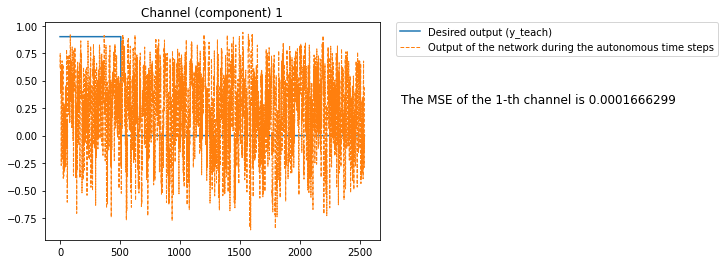

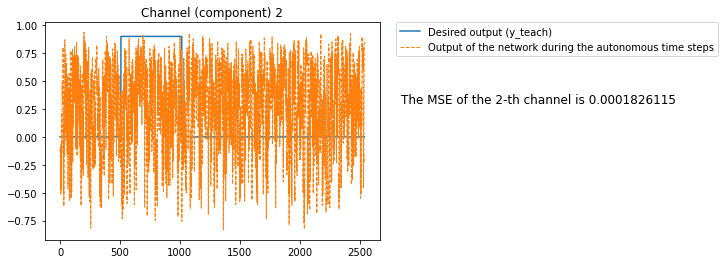

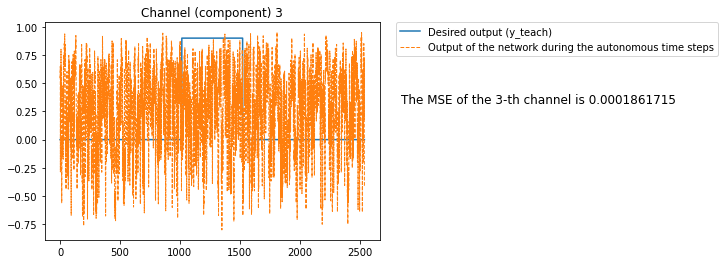

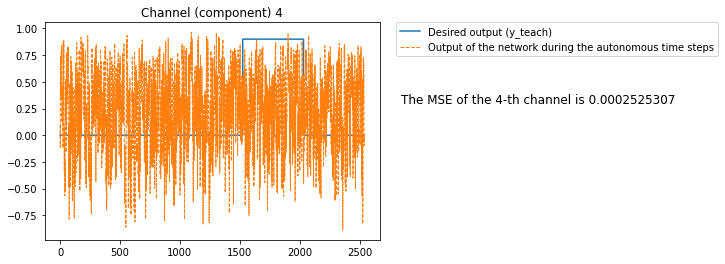

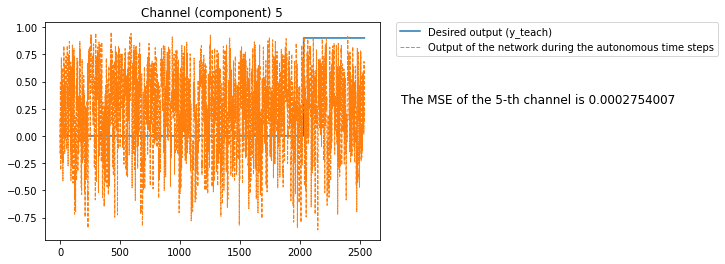

The test MSE for the 1-th dimension is 0.00016662985807212058
The test MSE for the 2-th dimension is 0.00018261154109148908
The test MSE for the 3-th dimension is 0.00018617148556208493
The test MSE for the 4-th dimension is 0.00025253065236842306
The test MSE for the 5-th dimension is 0.0002754007261588993


In [25]:
Network.final_test_network(t_autonom=2540, plot=True)